In [1]:
import lmdb
import datetime
import argparse
import pandas as pd
import numpy as np
import random
import re
from collections import defaultdict
from typing import List, Tuple, Union
import argparse

import scipy.io
import pickle
import os
import h5py

import torch
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from tqdm import tqdm

from torch.optim import AdamW
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

import math
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [29]:
TORCHEEG_2DGRID = [
    ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
    ['-', '-', '-', '-', 'FP1', 'FPZ', 'FP2', '-', '-', '-', '-'],
    ['-', '-', 'AF7', '-', 'AF3', 'AFZ', 'AF4', '-', 'AF8', '-', '-'],
    ['F9', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'F10'],
    ['FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10'], 
    ['T9', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'T10'],
    ['TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10'], 
    ['P9', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'P10'],
    ['-', '-', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', '-', '-'],
    ['-', '-', '-', 'CB1', 'O1', 'OZ', 'O2', 'CB2', '-', '-', '-'],
    ['-', '-', '-', '-', '-', 'IZ', '-', '-', '-', '-', '-']
    ]

def build_channel_to_rc(grid_2d):
    ch2rc = {}
    H = len(grid_2d)
    W = len(grid_2d[0])
    for r in range(H):
        for c in range(W):
            ch = grid_2d[r][c]
            if ch != '-' and ch is not None:
                ch2rc[str(ch).strip().upper()] = (r, c)
    return ch2rc, H, W

CHANNEL_TO_RC, H, W = build_channel_to_rc(TORCHEEG_2DGRID)

def to_tensor(array):
    return torch.from_numpy(array).float()

def random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f'set seed {seed} is done')

KeyT = Union[str, bytes, bytearray]

_KEY_RE = re.compile(
   r"^S(?P<sub_id>\d{3})R\d{2}-\d+$"
)

def _decode_key(k: KeyT) -> str:
    if isinstance(k, (bytes, bytearray)):
        return k.decode("utf-8", errors="ignore")
    return k

def _extract_sub_id(k: KeyT) -> str:
    s = _decode_key(k)
    m = _KEY_RE.match(s)
    if m is None:
        raise ValueError(f"Key does not match expected patterns: {s}")
    return m.group("sub_id")


def train_test_split_by_fold_num(
    fold_num: int,
    lmdb_keys: List[KeyT],
    maxFold: int,
    split_by_sub: bool = True,
    seed: int = 41
) -> Tuple[List[KeyT], List[KeyT]]:
    """
    True k-fold cross-validation split.

    Args:
        fold_num: test fold index (0 <= fold_num < maxFold)
        lmdb_keys: LMDB key list
        maxFold: total number of folds (k)
        split_by_sub: True → subject-wise k-fold, False → key-wise k-fold

    Returns:
        train_key_list, test_key_list
    """
    if maxFold < 2:
        raise ValueError("maxFold must be >= 2.")
    if fold_num < 0 or fold_num >= maxFold:
        raise ValueError(f"fold_num must be in [0, {maxFold-1}]")

    keys = list(lmdb_keys)

    rng = np.random.default_rng(seed)

    if split_by_sub:
        # -------- subject-wise k-fold --------
        sub_to_keys = defaultdict(list)
        invalid = []

        for k in keys:
            try:
                sid = _extract_sub_id(k)
                sub_to_keys[sid].append(k)
            except ValueError:
                invalid.append(_decode_key(k))

        if invalid:
            ex = "\n".join(invalid[:10])
            raise ValueError(
                f"Found {len(invalid)} invalid keys. Examples:\n{ex}"
            )

        subjects = np.array(list(sub_to_keys.keys()), dtype=object)
        rng.shuffle(subjects)

        subj_folds = np.array_split(subjects, maxFold)
        test_subjects = set(subj_folds[fold_num].tolist())

        train_keys, test_keys = [], []
        for sid, ks in sub_to_keys.items():
            (test_keys if sid in test_subjects else train_keys).extend(ks)

        return train_keys, test_keys

    else:
        # -------- key-wise k-fold --------
        idx = np.arange(len(keys))
        rng.shuffle(idx)

        folds = np.array_split(idx, maxFold)
        test_idx = set(folds[fold_num].tolist())

        train_keys = [keys[i] for i in idx if i not in test_idx]
        test_keys  = [keys[i] for i in idx if i in test_idx]

        return train_keys, test_keys

#################### Dataset classes ####################

print("DATASET SETTING RUNNING")

class Physio_1sec_raw_for_SOLID_from_lmdb(Dataset):
    def __init__(
            self,
            lmdb_dir: str,
            maxfold: int,
            targetfold: int,
            seed: int,
            train: bool,
            split_by_sub: bool,
            seg_len_sec: int = 1,
            stride_sec: int = 1,
            mean: float = 0.0,
            std: float = 1.0,
            p1: float = None,
            p99: float = None
    ):
        random_seed(seed)
        self.seed = seed
        self.lmdb_dir = lmdb_dir
        self.db = lmdb.open(lmdb_dir, readonly=True, lock=False, readahead=True, meminit=False)
        with self.db.begin(write=False) as txn:
            self.lmdb_keys = pickle.loads(txn.get('__keys__'.encode()))

        self.train = train
        self.split_by_sub = split_by_sub

        self.maxfold = maxfold
        self.targetfold = targetfold

        self.seg_len_sec = seg_len_sec
        self.stride_sec = stride_sec

        self.data, self.data_meta = self.make_segments_by_fold(
            self.targetfold, self.lmdb_keys, self.maxfold, self.split_by_sub, self.seed
        )

        if self.train:
            self._compute_mean_std(seed=seed)
        else:
            self.mean = float(mean)
            self.std  = float(std)
            self.p1 = float(p1)
            self.p99 = float(p99)

    def make_segments_by_fold(self, fold, lmdb_keys, maxfold, split_by_sub, seed):
        train_keys, test_keys = train_test_split_by_fold_num(
            fold, lmdb_keys, maxfold, split_by_sub, seed
        )

        use_keys = train_keys if self.train else test_keys

        all_segs = []
        all_meta = []

        for key in use_keys:
            seg_list, meta_list = self.segment_1sec_from_key(
                key, self.db,
                seg_len_sec=self.seg_len_sec,
                stride_sec=self.stride_sec
            )
            all_segs += seg_list
            all_meta += meta_list

        return all_segs, all_meta

    def lmdb_get(self, env, key):
        if isinstance(key, str):
            key = key.encode("utf-8")
        with env.begin(write=False) as txn:
            v = txn.get(key)
        if v is None:
            raise KeyError(f"Key not found: {key}")
        return pickle.loads(v)

    def segment_1sec_from_key(self, key, lmdb_db, seg_len_sec=1, stride_sec=1):
        """
        sample_for_key['sample'] shape: (C, T, Fs)
          - 여기서 T는 '초 단위 프레임 수'이고
          - Fs는 1초 내 샘플 수(예: 200)

        seg_len_sec=1이면:
          x = eeg[:, t, :] -> (C, Fs)

        seg_len_sec>1이면:
          x = eeg[:, t:t+seg_len_sec, :] -> (C, seg_len_sec, Fs) -> flatten -> (C, seg_len_sec*Fs)
        """
        sample_for_key = self.lmdb_get(lmdb_db, key)

        channel_name = sample_for_key['data_info']['channel_names']  # len=C
        eeg = sample_for_key['sample']  # (C, T, Fs), numpy

        if isinstance(eeg, torch.Tensor):
            eeg_t = eeg.float()
        else:
            eeg_t = torch.from_numpy(eeg).to(torch.float32)

        C, T, Fs = eeg_t.shape

        if T < seg_len_sec:
            return [], []

        seg_list = []
        meta_list = []

        for t in range(0, T - seg_len_sec + 1, stride_sec):
            x = eeg_t[:, t:t+seg_len_sec, :]          # (C, seg_len_sec, Fs)
            x = x.reshape(C, seg_len_sec * Fs)        # (C, seg_len_sec*Fs)  -> seg_len_sec=1이면 (C, Fs)

            seg_list.append(x)
            meta_list.append(channel_name)

        return seg_list, meta_list

    def _compute_mean_std(self, p_lo=0.1, p_hi=99.9, max_samples=2_000_000, seed=0):
        """
        Compute mean/std over the entire TRAIN dataset (streaming),
        and estimate percentiles (p_lo, p_hi) via random subsampling to avoid memory blow-up.

        Args:
            p_lo, p_hi: percentiles to compute (e.g., 1.0 and 99.0)
            max_samples: maximum number of scalar samples kept for percentile estimation
            seed: random seed for reproducibility
        """
        print("[PhysioDataset] Computing mean/std (+ percentiles) from TRAIN set...")

        total_sum = 0.0
        total_sq  = 0.0
        total_n   = 0

        # --- percentile sampling state ---
        g = torch.Generator()
        g.manual_seed(int(seed))

        samples = []          # list of 1D tensors (cpu) to concat at end
        kept = 0              # number of scalars kept so far

        # helper: take up to 'k' random scalars from a tensor x
        def _take_random_scalars(x_flat, k):
            if k <= 0:
                return None
            n = x_flat.numel()
            if n <= k:
                return x_flat.detach().cpu()
            idx = torch.randint(0, n, (k,), generator=g, device=x_flat.device)
            return x_flat[idx].detach().cpu()

        for x in self.data:
            # x: (C, L)
            x = x.float()

            # --- mean/std streaming ---
            total_sum += x.sum().item()
            total_sq  += (x ** 2).sum().item()
            total_n   += x.numel()

            # --- percentile subsampling ---
            # keep roughly up to max_samples scalars across the whole dataset
            # strategy: per item, keep min(remaining_budget, some_cap) random points
            if kept < max_samples:
                remaining = max_samples - kept
                # cap per sample so one item doesn't dominate (tuneable)
                per_item_cap = 50_000
                k = min(remaining, per_item_cap)

                x_flat = x.reshape(-1)
                picked = _take_random_scalars(x_flat, k)
                if picked is not None and picked.numel() > 0:
                    samples.append(picked)
                    kept += picked.numel()

        # finalize mean/std
        mean = total_sum / total_n
        var  = total_sq / total_n - mean ** 2
        std  = math.sqrt(var) if var > 0 else 1.0

        self.mean = float(mean)
        self.std  = float(std)

        # finalize percentiles (approx)
        if kept == 0:
            # fallback: degenerate case
            self.p1 = float(self.mean - 2 * self.std)
            self.p99 = float(self.mean + 2 * self.std)
            print("[PhysioDataset] WARNING: no samples collected for percentiles; using mean±2std fallback.")
            return

        v = torch.cat(samples, dim=0).float()

        # torch.quantile expects q in [0,1]
        q_lo = float(p_lo) / 100.0
        q_hi = float(p_hi) / 100.0

        p_lo_val = torch.quantile(v, q_lo).item()
        p_hi_val = torch.quantile(v, q_hi).item()

        # safety: avoid zero range
        if abs(p_hi_val - p_lo_val) < 1e-12:
            p_lo_val = float(self.mean - 2 * self.std)
            p_hi_val = float(self.mean + 2 * self.std)
            print("[PhysioDataset] WARNING: percentile range too small; using mean±2std fallback.")

        # store
        # 관례적으로 p1/p99라고 부르고 싶으면 p_lo=1, p_hi=99로 호출하면 됨
        self.p1  = float(p_lo_val)
        self.p99 = float(p_hi_val)

        print(f"[PhysioDataset] mean={self.mean:.6f}, std={self.std:.6f}, "
            f"p{p_lo:g}={self.p1:.6f}, p{p_hi:g}={self.p99:.6f}, kept={kept}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x  = self.data[idx]        # (C, 200) if seg_len_sec=1 and Fs=200
        xm = self.data_meta[idx]   # channel names
        return x, xm

def splat_eeg_grid(eeg_cl, channel_names, channel_to_rc=CHANNEL_TO_RC, H=H, W=W):
    """
    eeg_cl: (C, L) torch.Tensor (권장)
    channel_names: list[str] len=C
    returns:
      grid: (L, H, W)
      mask: (H, W)
    """
    if not torch.is_tensor(eeg_cl):
        eeg_cl = torch.as_tensor(eeg_cl)

    assert eeg_cl.dim() == 2, f"Expected (C,L), got {tuple(eeg_cl.shape)}"
    C, L = eeg_cl.shape
    device = eeg_cl.device

    grid = torch.zeros((L, H, W), dtype=eeg_cl.dtype, device=device)
    cnt  = torch.zeros((H, W), dtype=torch.float32, device=device)

    for ci in range(C):
        ch = str(channel_names[ci]).strip().upper()
        if ch in channel_to_rc:
            r, c = channel_to_rc[ch]
            grid[:, r, c] += eeg_cl[ci, :]
            cnt[r, c] += 1.0

    mask = (cnt > 0).float()
    grid = torch.where(cnt > 0, grid / torch.clamp(cnt, min=1.0), grid)
    return grid, mask

class EEGToGridCtx9_1sec(Dataset):
    """
    NEW VERSION for 1-sec raw base dataset.

    base[idx] -> (x, xm)
      x  : (C, L)  (torch or numpy)  e.g. (64, 200)
      xm : channel list (len=C)

    return:
      x0        : (L, H, W)   full target grid in tanh space (optional)
      loss_mask : (1, H, W)   1=supervise bins (typically UNOBSERVED electrode bins)
      cond      : (L+3, H, W) = [lat_map(1), lon_map(1), obs_grid(L), obs_mask(1)]
      mean, std
    """
    def __init__(
        self,
        base_dataset,
        squash_tanh: bool = True,
        channel_to_rc=CHANNEL_TO_RC,
        keep_ratio: float = 0.9,          # fraction of electrode bins observed
        seed: int = 0,
        loss_mode: str = 'all' # True면 (1-obs)에서만 loss
    ):
        self.base = base_dataset
        self.squash = squash_tanh
        self.channel_to_rc = channel_to_rc
        self.keep_ratio = keep_ratio
        self.seed = seed
        self.loss_mode = loss_mode

        self.mean = float(getattr(self.base, "mean", 0.0))
        self.std  = float(getattr(self.base, "std",  1.0))

        self.p1 = float(getattr(self.base, "p1", -100))
        self.p99 = float(getattr(self.base, "p99", 100))

        lat = torch.linspace(0, 1, H).unsqueeze(1).repeat(1, W)
        lon = torch.linspace(0, 1, W).unsqueeze(0).repeat(H, 1)
        self.lat_map = lat
        self.lon_map = lon

    def __len__(self):
        return len(self.base)

    def _sample_obs_mask(self, tgt_mask_hw: torch.Tensor, idx: int) -> torch.Tensor:
        """
        tgt_mask_hw: (H,W)  1 where electrode exists
        returns obs_mask_hw: (H,W) subset of tgt_mask_hw set to 1
        """
        g = torch.Generator(device=tgt_mask_hw.device)
        g.manual_seed(self.seed + idx)

        valid = torch.nonzero(tgt_mask_hw > 0.5, as_tuple=False)  # (N,2)
        N = valid.shape[0]
        if N == 0:
            return torch.zeros_like(tgt_mask_hw)

        k = max(1, int(round(self.keep_ratio * N)))
        perm = torch.randperm(N, generator=g, device=tgt_mask_hw.device)
        chosen = valid[perm[:k]]

        obs = torch.zeros_like(tgt_mask_hw)
        obs[chosen[:, 0], chosen[:, 1]] = 1.0
        return obs

    def __getitem__(self, idx):
        # base: (C,L), channel_names
        x, xm = self.base[idx]

        if not torch.is_tensor(x):
            x = torch.as_tensor(x, dtype=torch.float32)
        else:
            x = x.to(torch.float32)

        # ---- full target grid/mask ----
        # grid: (L,H,W), mask: (H,W)
        full_grid, tgt_mask_hw = splat_eeg_grid(
            x, xm, channel_to_rc=self.channel_to_rc, H=H, W=W
        )

        # (optional) squash to tanh space
        if self.squash:
            # z = (full_grid - self.mean) / (self.std + 1e-6)
            # x0 = torch.tanh(z)
            z = (full_grid - self.p1) / (self.p99 - self.p1 + 1e-6)   # [0,1] 근처
            z = 2*z - 1                                 # [-1,1]

            x0 = z.clamp(-1, 1) # hard clamp
            x0 = torch.tanh(z) # soft clamp
        else:
            x0 = full_grid/params.data_scaling_factor  # (L,H,W)

        # DEBUG PRINT
        if self.squash and idx == 0:
            with torch.no_grad():
                z = (full_grid - self.mean) / (self.std + 1e-6)
                sat = (x0.abs() > 0.98).float().mean().item()
                print(f"[DS] mean={self.mean:.4f} std={self.std:.4f} | "
                    f"z: min={z.min():.2f} max={z.max():.2f} p(|z|>3)={(z.abs()>3).float().mean():.3f} | "
                    f"x0: min={x0.min():.2f} max={x0.max():.2f} sat(|x0|>0.98)={sat:.3f}")

        # ---- observed subset mask (spatial only) ----
        obs_mask_hw = self._sample_obs_mask(tgt_mask_hw, idx)     # (H,W)

        # ---- observed input grid ----
        obs_grid = x0 * obs_mask_hw.unsqueeze(0)                  # (L,H,W)

        L = full_grid.shape[0]
        t_index = torch.linspace(
            0.0, 1.0, steps=L, device=full_grid.device
        ).view(L, 1, 1).expand(L, H, W)

        # ---- cond ----
        
        cond = torch.cat([
            self.lat_map.unsqueeze(0),            # (1,H,W)
            self.lon_map.unsqueeze(0),            # (1,H,W)
            # t_index,                              # (L,H,W)
            obs_grid,                             # (L,H,W) # FIXME : 시간축 이거 필요 없을지도? 뺴고 한 번 넣고 한 번 해보자
            obs_mask_hw.unsqueeze(0),             # (1,H,W)
        ], dim=0)                                 # (L+3,H,W)
        
        '''
        cond = torch.cat([
            self.lat_map.unsqueeze(0),            # (1,H,W)
            self.lon_map.unsqueeze(0),            # (1,H,W)
            obs_mask_hw.unsqueeze(0),             # (1,H,W)
        ], dim=0)  
        '''

        # ---- loss mask: where to supervise ----
        # electrode bins only (tgt_mask_hw) + (unobserved OR observed)
        if self.loss_mode == 'all':
            loss_mask_hw = tgt_mask_hw      # (H,W)
        elif self.loss_mode == 'obs':
            loss_mask_hw = obs_mask_hw * tgt_mask_hw            # (H,W)
        elif self.loss_mode == "unobs":
            loss_mask_hw = (1.0 - obs_mask_hw) * tgt_mask_hw              # (H,W)
        else :
            raise ValueError('loss_mode is weird')

        return x0, loss_mask_hw.unsqueeze(0), cond, self.mean, self.std

DATASET SETTING RUNNING


In [30]:
sample_train_dataset_1sec = Physio_1sec_raw_for_SOLID_from_lmdb(lmdb_dir="/pscratch/sd/t/tylee/Dataset/PhysioNet_200Hz_lowpass40_for_SOLID",
                                                     maxfold=5,
                                                     targetfold=0,
                                                     seed=41,
                                                     train=True,
                                                     split_by_sub=True)

sample_test_dataset_1sec = Physio_1sec_raw_for_SOLID_from_lmdb(lmdb_dir="/pscratch/sd/t/tylee/Dataset/PhysioNet_200Hz_lowpass40_for_SOLID",
                                                     maxfold=5,
                                                     targetfold=0,
                                                     seed=41,
                                                     train=False,
                                                     split_by_sub=True,
                                                     mean=sample_train_dataset_1sec.mean,
                                                     std=sample_train_dataset_1sec.std,
                                                     p1=sample_train_dataset_1sec.p1,
                                                     p99=sample_train_dataset_1sec.p99)

set seed 41 is done
[PhysioDataset] Computing mean/std (+ percentiles) from TRAIN set...
[PhysioDataset] mean=0.000000, std=36.489251, p0.1=-82.729942, p99.9=87.025177, kept=2000000
set seed 41 is done


In [4]:
train_grid_dataset = EEGToGridCtx9_1sec(base_dataset=sample_train_dataset_1sec, 
                                        squash_tanh=True, # TODO : tanh is bset option??
                                        channel_to_rc=CHANNEL_TO_RC,
                                        keep_ratio=0.9, # TODO : sparsity option should be added
                                        seed=41,
                                        loss_mode='all')

test_grid_dataset = EEGToGridCtx9_1sec(base_dataset=sample_test_dataset_1sec, 
                                        squash_tanh=True,
                                        channel_to_rc=CHANNEL_TO_RC,
                                        keep_ratio=0.9,
                                        seed=41,
                                        loss_mode='all')

train_loader = DataLoader(train_grid_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_grid_dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=2, pin_memory=True)

In [31]:
train_grid_dataset_percentile = EEGToGridCtx9_1sec(base_dataset=sample_train_dataset_1sec, 
                                        squash_tanh=True, # TODO : tanh is bset option??
                                        channel_to_rc=CHANNEL_TO_RC,
                                        keep_ratio=0.9, # TODO : sparsity option should be added
                                        seed=41,
                                        loss_mode='all')

test_grid_dataset_percentile = EEGToGridCtx9_1sec(base_dataset=sample_test_dataset_1sec, 
                                        squash_tanh=True,
                                        channel_to_rc=CHANNEL_TO_RC,
                                        keep_ratio=0.9,
                                        seed=41,
                                        loss_mode='all')

train_loader_percentile = DataLoader(train_grid_dataset_percentile, batch_size=32, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
test_loader_percentile = DataLoader(test_grid_dataset_percentile, batch_size=32, shuffle=False, drop_last=False, num_workers=2, pin_memory=True)

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def dataset_stats_and_viz(dataset, n_batches=200, batch_size=16, device='cpu',
                          sample_key=0,  # dataset[i]가 tuple이면 x가 몇 번째인지
                          flatten_for_hist=True,
                          max_hist_values=200_000,
                          title='Dataset stats'):
    """
    dataset: torch.utils.data.Dataset
    - dataset[i] -> x or (x, y, ...)
    n_batches: 너무 크면 오래 걸리니까 앞에서부터 일부 배치만 사용할 수 있게
    sample_key: tuple 반환 시 x 위치
    """

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Welford for mean/std (streaming)
    n = 0
    mean = None
    M2 = None
    gmin = None
    gmax = None

    # 히스토그램용 값 샘플링(너무 커지는 것 방지)
    hist_buf = []

    for b, batch in enumerate(loader):
        if b >= n_batches:
            break

        x = batch
        if isinstance(batch, (list, tuple)):
            x = batch[sample_key]

        x = x.to(device).detach()
        x_float = x.float()

        # global min/max
        bmin = x_float.amin().item()
        bmax = x_float.amax().item()
        gmin = bmin if gmin is None else min(gmin, bmin)
        gmax = bmax if gmax is None else max(gmax, bmax)

        # Welford 업데이트 (전체 원소 기준)
        x_flat = x_float.reshape(-1)
        bn = x_flat.numel()
        bmean = x_flat.mean()
        bM2 = ((x_flat - bmean) ** 2).sum()

        if mean is None:
            mean = bmean
            M2 = bM2
            n = bn
        else:
            delta = bmean - mean
            new_n = n + bn
            mean = mean + delta * (bn / new_n)
            M2 = M2 + bM2 + (delta ** 2) * (n * bn / new_n)
            n = new_n

        # hist buffer
        if flatten_for_hist:
            vals = x_flat
            # 너무 많으면 랜덤 샘플링
            if vals.numel() > 50_000:
                idx = torch.randperm(vals.numel(), device=vals.device)[:50_000]
                vals = vals[idx]
            hist_buf.append(vals.cpu())

    var = (M2 / (n - 1)).item() if n > 1 else float('nan')
    std = float(np.sqrt(var)) if var == var else float('nan')  # nan-safe
    mean_val = mean.item() if mean is not None else float('nan')

    # percentile (hist_buf 기반)
    if len(hist_buf) > 0:
        all_vals = torch.cat(hist_buf)
        if all_vals.numel() > max_hist_values:
            idx = torch.randperm(all_vals.numel())[:max_hist_values]
            all_vals = all_vals[idx]
        v_np = all_vals.numpy()
        pcts = np.percentile(v_np, [1, 5, 50, 95, 99])
    else:
        v_np = None
        pcts = [np.nan]*5

    # ---- print stats ----
    print(f'[{title}]')
    print(f'used batches: {min(n_batches, b+1)}')
    print(f'count (elements): {n:,}')
    print(f'mean: {mean_val:.6f}')
    print(f'std : {std:.6f}')
    print(f'min : {gmin:.6f}')
    print(f'max : {gmax:.6f}')
    print(f'percentiles [1,5,50,95,99]: {pcts}')

    # ---- viz ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # histogram
    if v_np is not None:
        xmin, xmax = np.percentile(v_np, [1, 99])
        axes[0].hist(v_np, bins=80)
        axes[0].set_xlim(xmin, xmax)
        axes[0].set_title('Value histogram (sampled)')
        axes[0].set_xlabel('value')
        axes[0].set_ylabel('count')
        for q, val in zip([1,5,50,95,99], pcts):
            axes[0].axvline(val, linestyle='--', linewidth=1)
            axes[0].text(val, axes[0].get_ylim()[1]*0.9, f'p{q}', rotation=90)

        # boxplot
        axes[1].boxplot(v_np, vert=True, showfliers=False)
        axes[1].set_title('Boxplot (sampled, no fliers)')
        axes[1].set_ylabel('value')
    else:
        axes[0].set_title('No values collected')
        axes[1].set_title('No values collected')

    plt.suptitle(f'{title} | mean={mean_val:.4f}, std={std:.4f}, min={gmin:.4f}, max={gmax:.4f}')
    plt.tight_layout()
    plt.show()

    return {
        'mean': mean_val, 'std': std, 'min': gmin, 'max': gmax,
        'p1': pcts[0], 'p5': pcts[1], 'p50': pcts[2], 'p95': pcts[3], 'p99': pcts[4],
        'n_elements': n
    }


[DS] mean=0.0000 std=36.4893 | z: min=-2.52 max=6.42 p(|z|>3)=0.002 | x0: min=-0.99 max=1.00 sat(|x0|>0.98)=0.004
[train_dataset]
used batches: 300
count (elements): 232,320,000
mean: -0.000495
std : 0.332029
min : -1.000000
max : 1.000000
percentiles [1,5,50,95,99]: [-9.67916700e-01 -6.53197095e-01 -2.94418413e-11  6.39653483e-01
  9.56781894e-01]


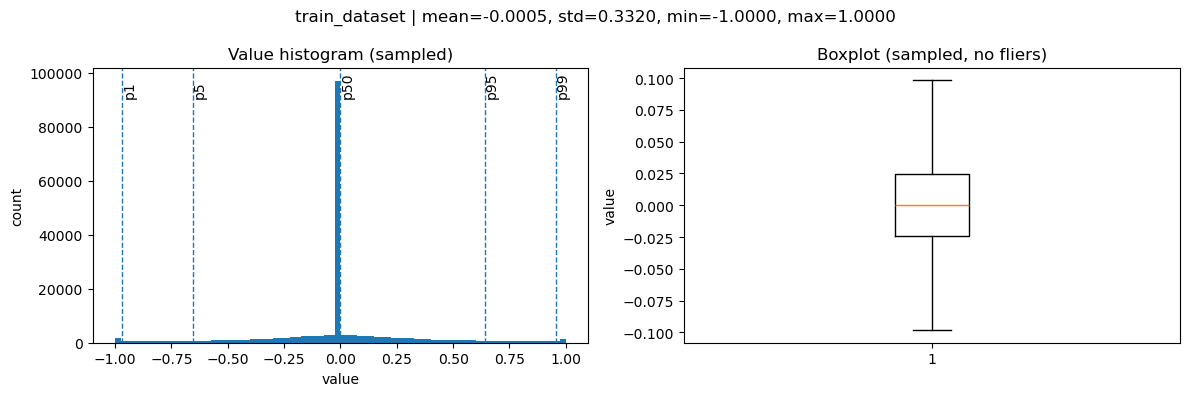

In [6]:
stats = dataset_stats_and_viz(train_grid_dataset, n_batches=300, batch_size=32, device='cpu', title='train_dataset')

[train_dataset_notgrid]
used batches: 300
count (elements): 122,880,000
mean: 0.000000
std : 33.732587
min : -1070.010132
max : 843.708740
percentiles [1,5,50,95,99]: [-1.00957623e+02 -4.37691355e+01  7.21973442e-02  4.17559122e+01
  9.59254650e+01]


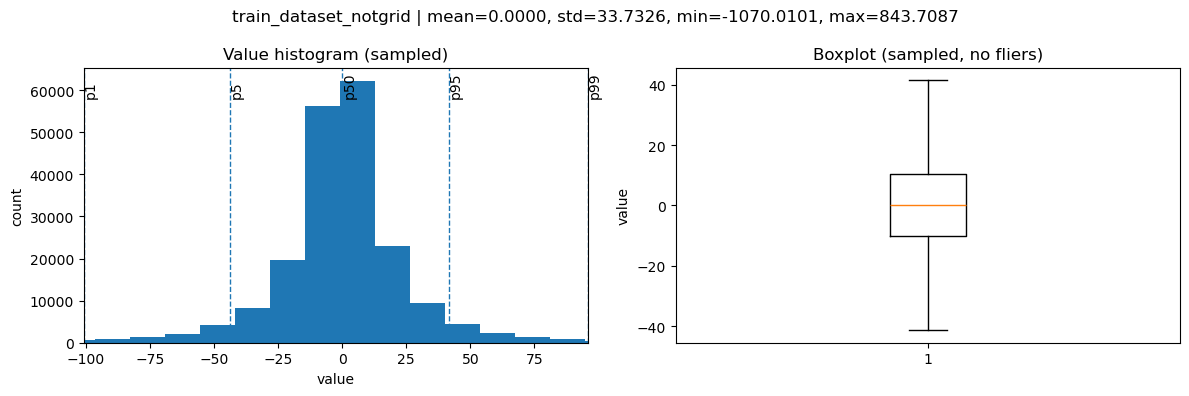

In [10]:
stats_1 = dataset_stats_and_viz(sample_train_dataset_1sec, n_batches=300, batch_size=32, device='cpu', title='train_dataset_notgrid')

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def dataset_stats_and_viz_mask(dataset, n_batches=200, batch_size=16, device='cpu',
                               x_key=0, mask_key=1,
                               flatten_for_hist=True,
                               max_hist_values=200_000,
                               title='Dataset stats (mask==1 only)'):

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    n = 0
    mean = None
    M2 = None
    gmin = None
    gmax = None
    hist_buf = []

    for b, batch in enumerate(loader):
        if b >= n_batches:
            break

        if not isinstance(batch, (list, tuple)):
            raise ValueError("Dataset must return (x, mask, ...)")

        x = batch[x_key].to(device).float()      # (B,T,H,W)
        mask = batch[mask_key].to(device)        # (B,1,H,W) or (B,H,W)

        # --- mask shape 맞추기 ---
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)               # (B,H,W)
        elif mask.dim() != 3:
            raise ValueError(f"Unexpected mask shape: {tuple(mask.shape)}")

        # --- T로 broadcast해서 valid 만들기 ---
        # x: (B,T,H,W) -> valid: (B,T,H,W)
        valid = (mask[:, None, :, :] > 0).expand_as(x)

        n_valid = valid.sum().item()
        if n_valid == 0:
            continue

        x_valid = x.masked_select(valid)         # (N_valid,)

        # --- min/max ---
        bmin = x_valid.min().item()
        bmax = x_valid.max().item()
        gmin = bmin if gmin is None else min(gmin, bmin)
        gmax = bmax if gmax is None else max(gmax, bmax)

        # --- Welford 업데이트 ---
        bn = x_valid.numel()
        bmean = x_valid.mean()
        bM2 = ((x_valid - bmean) ** 2).sum()

        if mean is None:
            mean = bmean
            M2 = bM2
            n = bn
        else:
            delta = bmean - mean
            new_n = n + bn
            mean = mean + delta * (bn / new_n)
            M2 = M2 + bM2 + (delta ** 2) * (n * bn / new_n)
            n = new_n

        # --- histogram buffer ---
        if flatten_for_hist:
            vals = x_valid
            if vals.numel() > 50_000:
                idx = torch.randperm(vals.numel(), device=vals.device)[:50_000]
                vals = vals[idx]
            hist_buf.append(vals.cpu())

    var = (M2 / (n - 1)).item() if n > 1 else float('nan')
    std = float(var ** 0.5) if var == var else float('nan')
    mean_val = mean.item() if mean is not None else float('nan')

    if len(hist_buf) > 0:
        all_vals = torch.cat(hist_buf)
        if all_vals.numel() > max_hist_values:
            idx = torch.randperm(all_vals.numel())[:max_hist_values]
            all_vals = all_vals[idx]
        v_np = all_vals.numpy()
        pcts = np.percentile(v_np, [1, 5, 50, 95, 99])
    else:
        v_np = None
        pcts = [np.nan] * 5

    print(f'[{title}]')
    print(f'used batches: {b+1}')
    print(f'valid elements: {n:,}')
    print(f'mean: {mean_val:.6f}')
    print(f'std : {std:.6f}')
    print(f'min : {gmin:.6f}')
    print(f'max : {gmax:.6f}')
    print(f'percentiles [1,5,50,95,99]: {pcts}')

    if v_np is not None:
        plt.figure(figsize=(6,4))
        plt.hist(v_np, bins=80)
        for q, val in zip([1,5,50,95,99], pcts):
            plt.axvline(val, linestyle='--', linewidth=1)
        plt.title(title)
        plt.xlabel('value')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()

    return {
        'mean': mean_val, 'std': std, 'min': gmin, 'max': gmax,
        'p1': pcts[0], 'p5': pcts[1], 'p50': pcts[2], 'p95': pcts[3], 'p99': pcts[4],
        'n_elements': n
    }



[DS] mean=0.0000 std=36.4893 | z: min=-2.52 max=6.42 p(|z|>3)=0.002 | x0: min=-0.99 max=1.00 sat(|x0|>0.98)=0.004
[train_dataset_obsgrid]
used batches: 301
valid elements: 122,880,000
mean: -0.000937
std : 0.456540
min : -1.000000
max : 1.000000
percentiles [1,5,50,95,99]: [-9.91688411e-01 -8.33155751e-01  7.04673206e-04  8.18948337e-01
  9.89934998e-01]


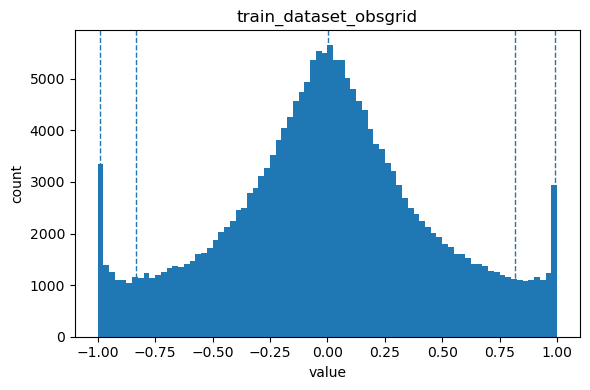

In [8]:
stats2 = dataset_stats_and_viz_mask(train_grid_dataset, n_batches=300, batch_size=32, device='cpu', title='train_dataset_obsgrid')

[DS] mean=0.0000 std=36.4893 | z: min=-2.52 max=6.42 p(|z|>3)=0.002 | x0: min=-0.80 max=0.99 sat(|x0|>0.98)=0.000
[train_dataset_obsgrid]
used batches: 301
valid elements: 122,880,000
mean: -0.024809
std : 0.275381
min : -1.000000
max : 1.000000
percentiles [1,5,50,95,99]: [-0.83622109 -0.49305551 -0.02466077  0.44275114  0.80607589]


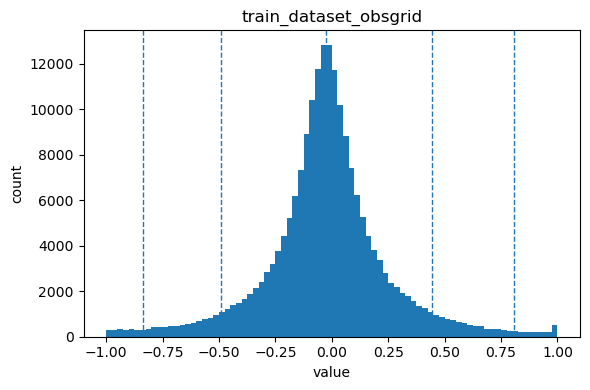

In [32]:
stats3 = dataset_stats_and_viz_mask(train_grid_dataset_percentile, n_batches=300, batch_size=32, device='cpu', title='train_dataset_obsgrid')

In [5]:
x0, mask, cond, mean, std = train_grid_dataset[0]

[DS] mean=0.0000 std=36.4893 | z: min=-2.52 max=6.42 p(|z|>3)=0.002 | x0: min=-0.99 max=1.00 sat(|x0|>0.98)=0.004


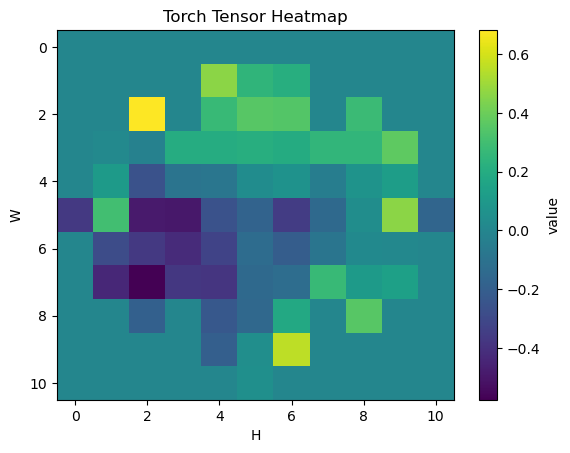

In [6]:
x_2d = x0[0,:,:]
plt.imshow(x_2d.cpu().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='value')
plt.title('Torch Tensor Heatmap')
plt.xlabel('H')
plt.ylabel('W')
plt.show()

/tmp/ipykernel_1790619/2392787841.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


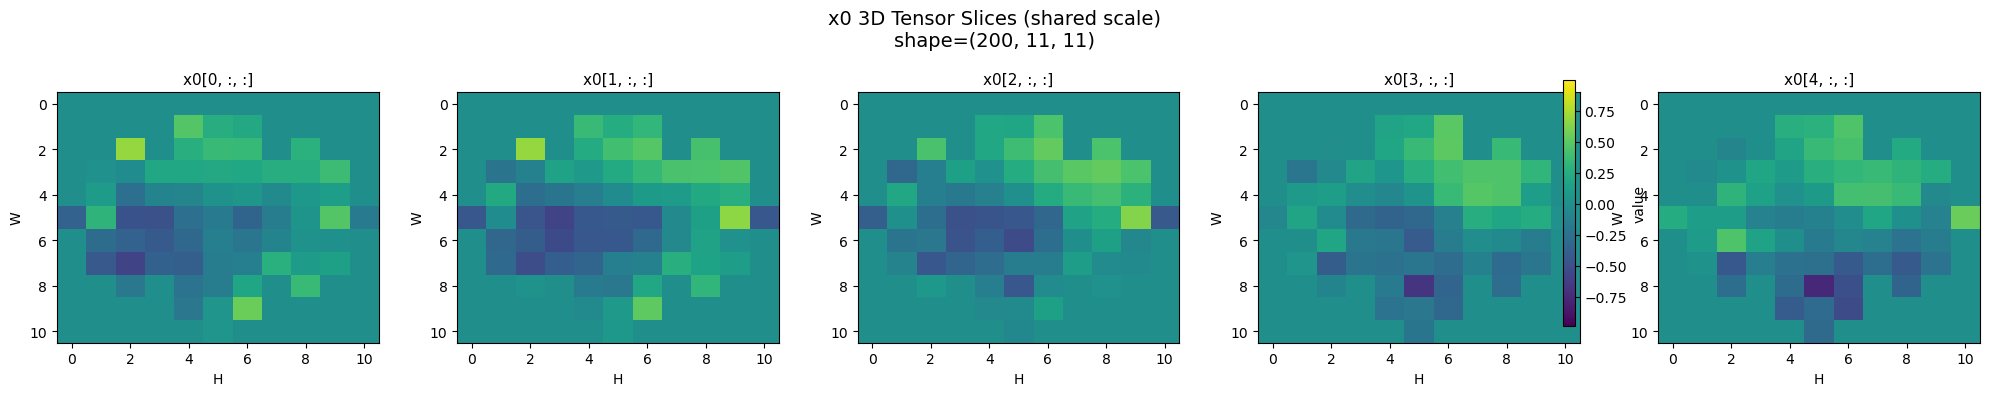

In [20]:
import matplotlib.pyplot as plt
import torch

# x0 shape 가정: [N, W, H] 또는 [N, H, W]
num_plots = min(5, x0.size(0))

# 🔹 전체 텐서 기준으로 공통 vmin / vmax 계산
vmin = x0.min().item()
vmax = x0.max().item()

fig, axes = plt.subplots(1, num_plots, figsize=(4*num_plots, 4))

for i in range(num_plots):
    x_2d = x0[i].detach().cpu().numpy()

    im = axes[i].imshow(
        x_2d,
        cmap='viridis',
        aspect='auto',
        vmin=vmin,
        vmax=vmax
    )
    axes[i].set_title(f'x0[{i}, :, :]', fontsize=11)
    axes[i].set_xlabel('H')
    axes[i].set_ylabel('W')

# 🔹 colorbar 하나만 공유 (모든 subplot 동일 스케일)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label('value')

plt.suptitle(f'x0 3D Tensor Slices (shared scale)\nshape={tuple(x0.shape)}', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
x0[0,:,:]

tensor([[-2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11,
         -2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11,
         -2.9442e-11],
        [-2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11,  4.6496e-01,
          2.4879e-01,  2.1401e-01, -2.9442e-11, -2.9442e-11, -2.9442e-11,
         -2.9442e-11],
        [-2.9442e-11, -2.9442e-11,  6.8217e-01, -2.9442e-11,  2.7019e-01,
          3.5360e-01,  3.4685e-01, -2.9442e-11,  2.7922e-01, -2.9442e-11,
         -2.9442e-11],
        [-2.9442e-11,  1.7100e-02, -2.2596e-02,  2.0058e-01,  2.0093e-01,
          2.1346e-01,  1.9611e-01,  2.5218e-01,  2.5116e-01,  3.7165e-01,
         -2.9442e-11],
        [-2.9442e-11,  1.0943e-01, -2.6073e-01, -9.2210e-02, -8.0867e-02,
          3.4807e-02,  6.4681e-02, -4.3439e-02,  7.0643e-02,  1.2639e-01,
         -2.9442e-11],
        [-3.6548e-01,  3.0230e-01, -4.8497e-01, -4.9700e-01, -2.6162e-01,
         -1.7526e-01, -3.5034e-01, -1.4809e-01,  3.8273e-02,  4.6521e-0

In [19]:
x0[4,:,:]

tensor([[-2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11,
         -2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11,
         -2.9442e-11],
        [-2.9442e-11, -2.9442e-11, -2.9442e-11, -2.9442e-11,  2.5524e-01,
          2.8271e-01,  4.5013e-01, -2.9442e-11, -2.9442e-11, -2.9442e-11,
         -2.9442e-11],
        [-2.9442e-11, -2.9442e-11, -8.3060e-02, -2.9442e-11,  1.7173e-01,
          3.5092e-01,  4.2384e-01, -2.9442e-11,  2.2508e-01, -2.9442e-11,
         -2.9442e-11],
        [-2.9442e-11, -4.3489e-02,  3.3153e-02,  1.7746e-01,  1.0978e-01,
          2.5825e-01,  3.2654e-01,  3.5460e-01,  3.0169e-01,  2.4658e-01,
         -2.9442e-11],
        [-2.9442e-11,  3.0036e-03,  3.0423e-01,  1.5192e-01,  1.6350e-02,
          9.8128e-02,  4.0926e-01,  4.1265e-01,  3.4860e-01, -4.8233e-02,
         -2.9442e-11],
        [ 2.4399e-01,  1.1928e-01,  1.2578e-01, -1.0762e-01, -1.4121e-01,
         -1.1480e-01, -9.6629e-03,  1.8755e-01,  1.3906e-02, -1.0798e-0

In [7]:
print(f"{x0.min()}, {x0.std()}")

-0.9870395064353943, 0.2656894624233246


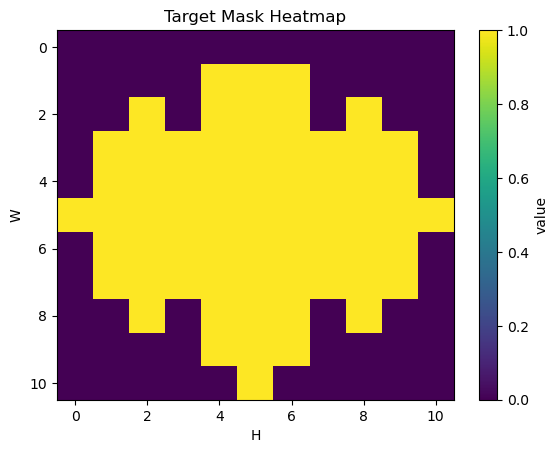

In [15]:
mask_2d = mask[0,:,:]

plt.imshow(mask_2d.cpu().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='value')
plt.title('Target Mask Heatmap')
plt.xlabel('H')
plt.ylabel('W')
plt.show()

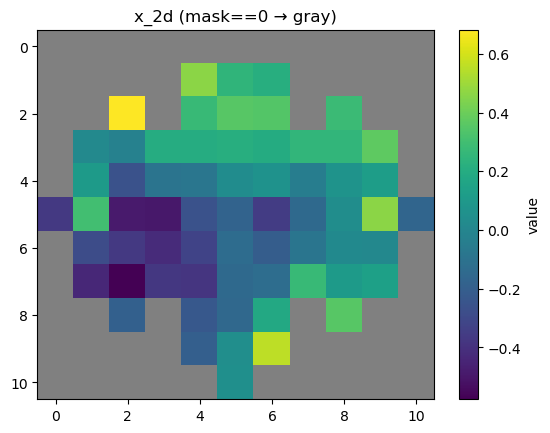

In [9]:
import numpy as np
import matplotlib.pyplot as plt

mask_2d = mask[0].cpu()
x_2d = x0[0].cpu()

# mask == 0 인 곳을 masked 처리
x_masked = np.ma.array(x_2d, mask=(mask_2d == 0))

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='gray')  # mask된 영역 색

plt.imshow(x_masked, cmap=cmap, aspect='auto')
plt.colorbar(label='value')
plt.title('x_2d (mask==0 → gray)')
plt.show()


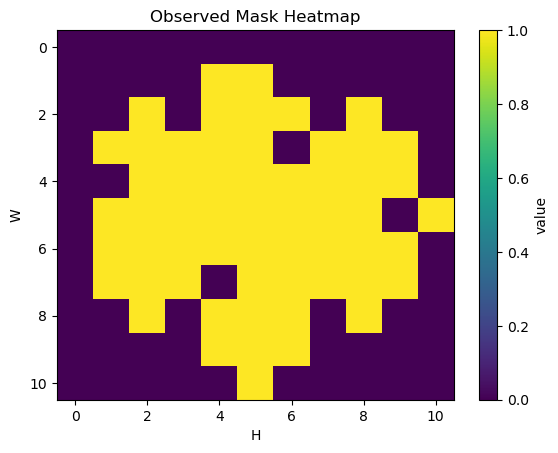

In [16]:
obs_mask = cond[-1, :,:]

plt.imshow(obs_mask.cpu().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='value')
plt.title('Observed Mask Heatmap')
plt.xlabel('H')
plt.ylabel('W')
plt.show()

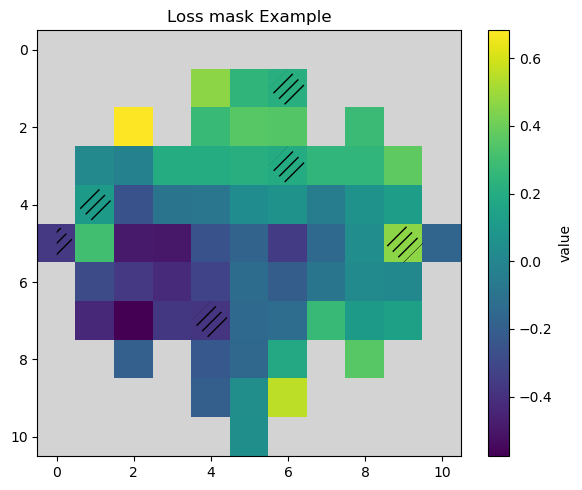

In [21]:
import numpy as np
import matplotlib.pyplot as plt

mask_2d = mask[0].cpu().numpy()
x_2d = x0[0].cpu().numpy()
obs_mask = cond[-1].cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 5))

# 1) mask==0 -> 회색 처리된 값 heatmap
x_masked = np.ma.array(x_2d, mask=(mask_2d == 0))
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='lightgray')

im = ax.imshow(x_masked, cmap=cmap, aspect='auto', interpolation='nearest')

# 2) mask==1 & obs==0 -> hatch만 (contourf로 안정적으로)
unobs = ((mask_2d == 1) & (obs_mask == 0)).astype(int)

# levels: 0/1 경계, colors='none'로 "색 없이 패턴만"
ax.contourf(
    unobs,
    levels=[0.5, 1.5],
    colors='none',
    hatches=['///']
)

plt.colorbar(im, ax=ax, label='value')
ax.set_title('Loss mask Example')
plt.tight_layout()
plt.show()



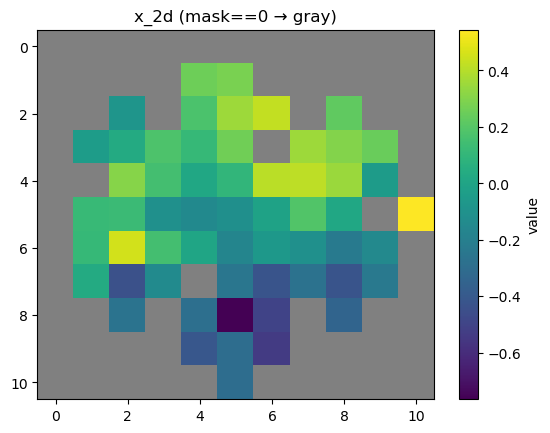

In [14]:
import numpy as np
import matplotlib.pyplot as plt

time = 4

mask_2d = cond[time+2].cpu()
x_2d = x0[time].cpu()

# mask == 0 인 곳을 masked 처리
x_masked = np.ma.array(x_2d, mask=(mask_2d == 0))

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='gray')  # mask된 영역 색

plt.imshow(x_masked, cmap=cmap, aspect='auto')
plt.colorbar(label='value')
plt.title('x_2d (mask==0 → gray)')
plt.show()